In [1]:
# mount gdrive

from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANDL/Homework_1

Mounted at /gdrive
/gdrive/My Drive/ANDL/Homework_1


In [2]:
#!unzip atMost700.zip

In [3]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import adam_v2

import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import random
import os
import tensorflow as tf
from PIL import Image

In [4]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [5]:
# Dataset folders 
dataset_dir = 'atMost700'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

labels = ['Species1','Species2','Species3','Species4','Species5','Species6','Species7','Species8',]

Text(0.5, 1.0, 'Number of training images per category:')

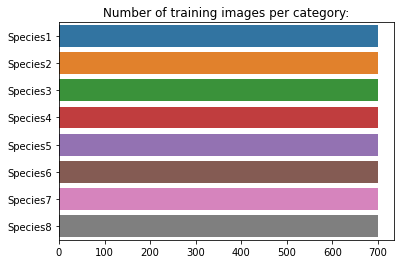

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
category_names = sorted(os.listdir(training_dir))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = training_dir + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img

# Create an instance of ImageDataGenerator with Data Augmentation
aug_train_data_gen = ImageDataGenerator(#rotation_range=180,
                                        height_shift_range=5,
                                        width_shift_range=5,
                                        #zoom_range=0.5,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        #fill_mode='nearest',
                                        preprocessing_function = preprocess_input,
                                        # rescale=1/255. not on vgg16
                                        ) 
valid_data_gen = ImageDataGenerator(#rescale=1/255.,
                                    preprocessing_function = preprocess_input)
test_data_gen = ImageDataGenerator(#rescale=1/255.,
                                   preprocessing_function = preprocess_input)

In [8]:
# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
aug_train_gen = aug_train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=32,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=seed)
test_gen = test_data_gen.flow_from_directory(directory=test_dir,
                                             target_size=(96,96),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=32,
                                             shuffle=False,
                                             seed=seed)

Found 5600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


In [9]:
def get_next_batch(generator):
  batch = next(generator)

  image = batch[0]
  target = batch[1]

  print("(Input) image shape:", image.shape)
  print("Target shape:",target.shape)

  # Visualize only the first sample
  image = image[0]
  target = target[0]
  target_idx = np.argmax(target)
  print()
  print("Categorical label:", target)
  print("Label:", target_idx)
  print("Class name:", labels[target_idx])
  fig = plt.figure(figsize=(6, 4))
  plt.imshow(np.uint8(image))

  return batch

(Input) image shape: (32, 96, 96, 3)
Target shape: (32, 8)

Categorical label: [0. 0. 0. 0. 0. 0. 1. 0.]
Label: 6
Class name: Species7


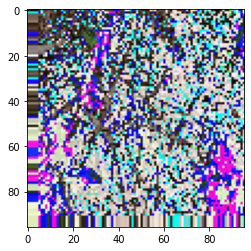

In [10]:
# Get a sample from dataset and show info
_ = get_next_batch(aug_train_gen)

In [11]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback  = tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                              

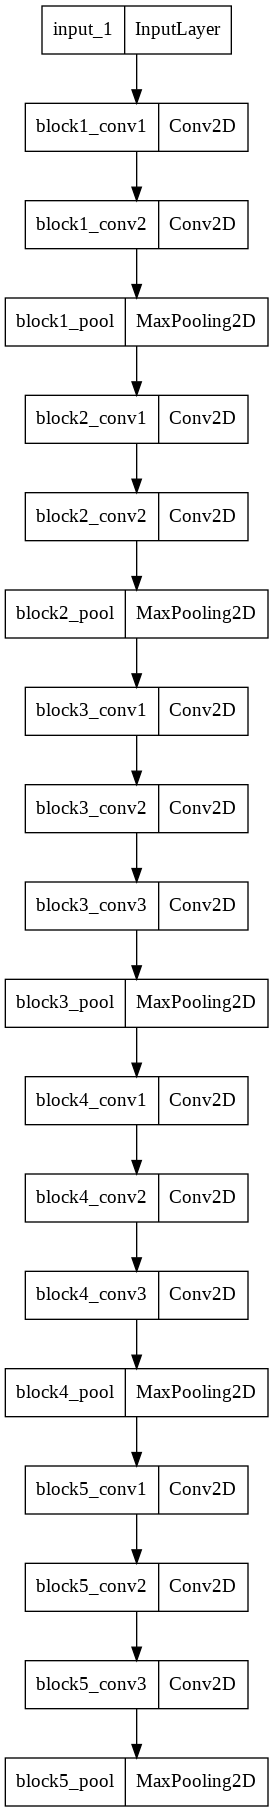

In [12]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [13]:
input_shape = (96, 96, 3)
epochs = 200

In [14]:
import tensorflow.keras.layers as tfkl

# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(96,96,3))
# No resize
#x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
x = supernet(inputs)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(x)



# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='model')

# Compile the model
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [15]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   layer.trainable = False

for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False


In [16]:
# Train the model
tl_callbacks = create_folders_and_callbacks(model_name = 'transfer_learning')

# Train the model
tl_history = tl_model.fit(
    x = aug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = tl_callbacks,
    #class_weight=class_weight
).history

Epoch 1/200
175/175 [==============================] - ETA: 0s - loss: 7.4103 - accuracy: 0.2796 - precision: 0.2826 - recall: 0.2702 

175/175 [==============================] - 2992s 17s/step - loss: 7.4103 - accuracy: 0.2796 - precision: 0.2826 - recall: 0.2702 - val_loss: 2.2605 - val_accuracy: 0.4535 - val_precision: 0.4742 - val_recall: 0.4194
Epoch 2/200
175/175 [==============================] - ETA: 0s - loss: 3.3836 - accuracy: 0.4125 - precision: 0.4285 - recall: 0.3943

175/175 [==============================] - 29s 164ms/step - loss: 3.3836 - accuracy: 0.4125 - precision: 0.4285 - recall: 0.3943 - val_loss: 1.5212 - val_accuracy: 0.4915 - val_precision: 0.5918 - val_recall: 0.4099
Epoch 3/200
175/175 [==============================] - ETA: 0s - loss: 2.3314 - accuracy: 0.4471 - precision: 0.4837 - recall: 0.4041

175/175 [==============================] - 28s 160ms/step - loss: 2.3314 - accuracy: 0.4471 - precision: 0.4837 - recall: 0.4041 - val_loss: 1.4058 - val_accuracy: 0.4763 - val_precision: 0.6517 - val_recall: 0.3302
Epoch 4/200
175/175 [==============================] - ETA: 0s - loss: 1.8816 - accuracy: 0.4495 - precision: 0.5062 - recall: 0.3738

175/175 [==============================] - 28s 162ms/step - loss: 1.8816 - accuracy: 0.4495 - precision: 0.5062 - recall: 0.3738 - val_loss: 1.3742 - val_accuracy: 0.4877 - val_precision: 0.7282 - val_recall: 0.2694
Epoch 5/200
175/175 [==============================] - ETA: 0s - loss: 1.6364 - accuracy: 0.4729 - precision: 0.5579 - recall: 0.3745

175/175 [==============================] - 28s 160ms/step - loss: 1.6364 - accuracy: 0.4729 - precision: 0.5579 - recall: 0.3745 - val_loss: 1.3425 - val_accuracy: 0.4877 - val_precision: 0.7196 - val_recall: 0.2581
Epoch 6/200
175/175 [==============================] - ETA: 0s - loss: 1.5103 - accuracy: 0.4911 - precision: 0.5901 - recall: 0.3814

175/175 [==============================] - 28s 161ms/step - loss: 1.5103 - accuracy: 0.4911 - precision: 0.5901 - recall: 0.3814 - val_loss: 1.3131 - val_accuracy: 0.5009 - val_precision: 0.7216 - val_recall: 0.2657
Epoch 7/200
175/175 [==============================] - ETA: 0s - loss: 1.3982 - accuracy: 0.5068 - precision: 0.5979 - recall: 0.3854

175/175 [==============================] - 28s 158ms/step - loss: 1.3982 - accuracy: 0.5068 - precision: 0.5979 - recall: 0.3854 - val_loss: 1.2578 - val_accuracy: 0.5142 - val_precision: 0.7744 - val_recall: 0.2865
Epoch 8/200
175/175 [==============================] - ETA: 0s - loss: 1.3485 - accuracy: 0.5291 - precision: 0.6373 - recall: 0.4098

175/175 [==============================] - 28s 159ms/step - loss: 1.3485 - accuracy: 0.5291 - precision: 0.6373 - recall: 0.4098 - val_loss: 1.2416 - val_accuracy: 0.5237 - val_precision: 0.7727 - val_recall: 0.2903
Epoch 9/200
175/175 [==============================] - ETA: 0s - loss: 1.2745 - accuracy: 0.5473 - precision: 0.6578 - recall: 0.4202

175/175 [==============================] - 28s 159ms/step - loss: 1.2745 - accuracy: 0.5473 - precision: 0.6578 - recall: 0.4202 - val_loss: 1.2037 - val_accuracy: 0.5427 - val_precision: 0.7626 - val_recall: 0.3169
Epoch 10/200
175/175 [==============================] - ETA: 0s - loss: 1.2334 - accuracy: 0.5620 - precision: 0.6700 - recall: 0.4507

175/175 [==============================] - 27s 156ms/step - loss: 1.2334 - accuracy: 0.5620 - precision: 0.6700 - recall: 0.4507 - val_loss: 1.1939 - val_accuracy: 0.5541 - val_precision: 0.7900 - val_recall: 0.3283
Epoch 11/200
175/175 [==============================] - ETA: 0s - loss: 1.1974 - accuracy: 0.5680 - precision: 0.6814 - recall: 0.4468

175/175 [==============================] - 28s 159ms/step - loss: 1.1974 - accuracy: 0.5680 - precision: 0.6814 - recall: 0.4468 - val_loss: 1.1573 - val_accuracy: 0.5655 - val_precision: 0.7447 - val_recall: 0.3321
Epoch 12/200
175/175 [==============================] - ETA: 0s - loss: 1.1612 - accuracy: 0.5855 - precision: 0.6927 - recall: 0.4702

175/175 [==============================] - 28s 158ms/step - loss: 1.1612 - accuracy: 0.5855 - precision: 0.6927 - recall: 0.4702 - val_loss: 1.1143 - val_accuracy: 0.5769 - val_precision: 0.7610 - val_recall: 0.3624
Epoch 13/200
175/175 [==============================] - ETA: 0s - loss: 1.1287 - accuracy: 0.5964 - precision: 0.6961 - recall: 0.4729

175/175 [==============================] - 28s 160ms/step - loss: 1.1287 - accuracy: 0.5964 - precision: 0.6961 - recall: 0.4729 - val_loss: 1.1201 - val_accuracy: 0.5693 - val_precision: 0.7846 - val_recall: 0.3662
Epoch 14/200
175/175 [==============================] - ETA: 0s - loss: 1.0660 - accuracy: 0.6066 - precision: 0.7165 - recall: 0.5046

175/175 [==============================] - 27s 156ms/step - loss: 1.0660 - accuracy: 0.6066 - precision: 0.7165 - recall: 0.5046 - val_loss: 1.0914 - val_accuracy: 0.5806 - val_precision: 0.7677 - val_recall: 0.3700
Epoch 15/200
175/175 [==============================] - ETA: 0s - loss: 1.0565 - accuracy: 0.6155 - precision: 0.7158 - recall: 0.5041

175/175 [==============================] - 28s 160ms/step - loss: 1.0565 - accuracy: 0.6155 - precision: 0.7158 - recall: 0.5041 - val_loss: 1.0736 - val_accuracy: 0.5920 - val_precision: 0.7575 - val_recall: 0.3852
Epoch 16/200
175/175 [==============================] - ETA: 0s - loss: 1.0048 - accuracy: 0.6286 - precision: 0.7378 - recall: 0.5271

175/175 [==============================] - 28s 158ms/step - loss: 1.0048 - accuracy: 0.6286 - precision: 0.7378 - recall: 0.5271 - val_loss: 1.0432 - val_accuracy: 0.5958 - val_precision: 0.7586 - val_recall: 0.4175
Epoch 17/200
175/175 [==============================] - ETA: 0s - loss: 1.0133 - accuracy: 0.6361 - precision: 0.7341 - recall: 0.5320

175/175 [==============================] - 28s 160ms/step - loss: 1.0133 - accuracy: 0.6361 - precision: 0.7341 - recall: 0.5320 - val_loss: 1.0477 - val_accuracy: 0.5958 - val_precision: 0.7554 - val_recall: 0.3985
Epoch 18/200
175/175 [==============================] - ETA: 0s - loss: 0.9676 - accuracy: 0.6516 - precision: 0.7536 - recall: 0.5511

175/175 [==============================] - 28s 157ms/step - loss: 0.9676 - accuracy: 0.6516 - precision: 0.7536 - recall: 0.5511 - val_loss: 1.0248 - val_accuracy: 0.6091 - val_precision: 0.7416 - val_recall: 0.4194
Epoch 19/200
175/175 [==============================] - ETA: 0s - loss: 0.9440 - accuracy: 0.6629 - precision: 0.7488 - recall: 0.5536

175/175 [==============================] - 28s 159ms/step - loss: 0.9440 - accuracy: 0.6629 - precision: 0.7488 - recall: 0.5536 - val_loss: 1.0160 - val_accuracy: 0.6072 - val_precision: 0.7484 - val_recall: 0.4516
Epoch 20/200
175/175 [==============================] - ETA: 0s - loss: 0.9331 - accuracy: 0.6641 - precision: 0.7508 - recall: 0.5611

175/175 [==============================] - 28s 157ms/step - loss: 0.9331 - accuracy: 0.6641 - precision: 0.7508 - recall: 0.5611 - val_loss: 1.0217 - val_accuracy: 0.6034 - val_precision: 0.7445 - val_recall: 0.4535
Epoch 21/200
175/175 [==============================] - ETA: 0s - loss: 0.8968 - accuracy: 0.6682 - precision: 0.7629 - recall: 0.5764

175/175 [==============================] - 28s 159ms/step - loss: 0.8968 - accuracy: 0.6682 - precision: 0.7629 - recall: 0.5764 - val_loss: 1.0023 - val_accuracy: 0.6034 - val_precision: 0.7695 - val_recall: 0.4497
Epoch 22/200
175/175 [==============================] - ETA: 0s - loss: 0.9120 - accuracy: 0.6707 - precision: 0.7602 - recall: 0.5745

175/175 [==============================] - 28s 157ms/step - loss: 0.9120 - accuracy: 0.6707 - precision: 0.7602 - recall: 0.5745 - val_loss: 1.0117 - val_accuracy: 0.6129 - val_precision: 0.7431 - val_recall: 0.4611
Epoch 23/200
175/175 [==============================] - ETA: 0s - loss: 0.8952 - accuracy: 0.6796 - precision: 0.7685 - recall: 0.5838

175/175 [==============================] - 28s 159ms/step - loss: 0.8952 - accuracy: 0.6796 - precision: 0.7685 - recall: 0.5838 - val_loss: 0.9916 - val_accuracy: 0.6148 - val_precision: 0.7456 - val_recall: 0.4839
Epoch 24/200
175/175 [==============================] - ETA: 0s - loss: 0.8750 - accuracy: 0.6798 - precision: 0.7621 - recall: 0.5818

175/175 [==============================] - 28s 158ms/step - loss: 0.8750 - accuracy: 0.6798 - precision: 0.7621 - recall: 0.5818 - val_loss: 0.9828 - val_accuracy: 0.6205 - val_precision: 0.7622 - val_recall: 0.4744
Epoch 25/200
175/175 [==============================] - ETA: 0s - loss: 0.8492 - accuracy: 0.6898 - precision: 0.7783 - recall: 0.6032

175/175 [==============================] - 29s 166ms/step - loss: 0.8492 - accuracy: 0.6898 - precision: 0.7783 - recall: 0.6032 - val_loss: 0.9796 - val_accuracy: 0.6129 - val_precision: 0.7328 - val_recall: 0.4839
Epoch 26/200
175/175 [==============================] - ETA: 0s - loss: 0.8328 - accuracy: 0.6948 - precision: 0.7742 - recall: 0.6148

175/175 [==============================] - 28s 159ms/step - loss: 0.8328 - accuracy: 0.6948 - precision: 0.7742 - recall: 0.6148 - val_loss: 0.9849 - val_accuracy: 0.6205 - val_precision: 0.7433 - val_recall: 0.4725
Epoch 27/200
175/175 [==============================] - ETA: 0s - loss: 0.8351 - accuracy: 0.6914 - precision: 0.7775 - recall: 0.6034

175/175 [==============================] - 28s 161ms/step - loss: 0.8351 - accuracy: 0.6914 - precision: 0.7775 - recall: 0.6034 - val_loss: 0.9539 - val_accuracy: 0.6357 - val_precision: 0.7686 - val_recall: 0.5104
Epoch 28/200
175/175 [==============================] - ETA: 0s - loss: 0.8150 - accuracy: 0.7068 - precision: 0.7880 - recall: 0.6234

175/175 [==============================] - 28s 161ms/step - loss: 0.8150 - accuracy: 0.7068 - precision: 0.7880 - recall: 0.6234 - val_loss: 0.9705 - val_accuracy: 0.6167 - val_precision: 0.7522 - val_recall: 0.4896
Epoch 29/200
175/175 [==============================] - ETA: 0s - loss: 0.7872 - accuracy: 0.7064 - precision: 0.7902 - recall: 0.6234

175/175 [==============================] - 28s 161ms/step - loss: 0.7872 - accuracy: 0.7064 - precision: 0.7902 - recall: 0.6234 - val_loss: 0.9575 - val_accuracy: 0.6262 - val_precision: 0.7418 - val_recall: 0.5123
Epoch 30/200
175/175 [==============================] - ETA: 0s - loss: 0.7667 - accuracy: 0.7195 - precision: 0.7936 - recall: 0.6475

175/175 [==============================] - 28s 158ms/step - loss: 0.7667 - accuracy: 0.7195 - precision: 0.7936 - recall: 0.6475 - val_loss: 0.9761 - val_accuracy: 0.6205 - val_precision: 0.7362 - val_recall: 0.4820
Epoch 31/200
175/175 [==============================] - ETA: 0s - loss: 0.7638 - accuracy: 0.7198 - precision: 0.8012 - recall: 0.6448

175/175 [==============================] - 28s 160ms/step - loss: 0.7638 - accuracy: 0.7198 - precision: 0.8012 - recall: 0.6448 - val_loss: 0.9557 - val_accuracy: 0.6357 - val_precision: 0.7486 - val_recall: 0.5028
Epoch 32/200
175/175 [==============================] - ETA: 0s - loss: 0.7450 - accuracy: 0.7287 - precision: 0.8058 - recall: 0.6513

175/175 [==============================] - 28s 158ms/step - loss: 0.7450 - accuracy: 0.7287 - precision: 0.8058 - recall: 0.6513 - val_loss: 0.9519 - val_accuracy: 0.6471 - val_precision: 0.7567 - val_recall: 0.5370
Epoch 33/200
175/175 [==============================] - ETA: 0s - loss: 0.7497 - accuracy: 0.7234 - precision: 0.7949 - recall: 0.6532

175/175 [==============================] - 28s 161ms/step - loss: 0.7497 - accuracy: 0.7234 - precision: 0.7949 - recall: 0.6532 - val_loss: 0.9452 - val_accuracy: 0.6319 - val_precision: 0.7527 - val_recall: 0.5199
Epoch 34/200
175/175 [==============================] - ETA: 0s - loss: 0.7372 - accuracy: 0.7280 - precision: 0.8087 - recall: 0.6554

175/175 [==============================] - 28s 159ms/step - loss: 0.7372 - accuracy: 0.7280 - precision: 0.8087 - recall: 0.6554 - val_loss: 0.9320 - val_accuracy: 0.6319 - val_precision: 0.7390 - val_recall: 0.5427
Epoch 35/200
175/175 [==============================] - ETA: 0s - loss: 0.7323 - accuracy: 0.7375 - precision: 0.8065 - recall: 0.6600

175/175 [==============================] - 28s 159ms/step - loss: 0.7323 - accuracy: 0.7375 - precision: 0.8065 - recall: 0.6600 - val_loss: 0.9209 - val_accuracy: 0.6338 - val_precision: 0.7297 - val_recall: 0.5275
Epoch 36/200
175/175 [==============================] - ETA: 0s - loss: 0.7082 - accuracy: 0.7405 - precision: 0.8044 - recall: 0.6734

175/175 [==============================] - 28s 157ms/step - loss: 0.7082 - accuracy: 0.7405 - precision: 0.8044 - recall: 0.6734 - val_loss: 0.9115 - val_accuracy: 0.6471 - val_precision: 0.7593 - val_recall: 0.5446
Epoch 37/200
175/175 [==============================] - ETA: 0s - loss: 0.6954 - accuracy: 0.7420 - precision: 0.8131 - recall: 0.6734

175/175 [==============================] - 28s 159ms/step - loss: 0.6954 - accuracy: 0.7420 - precision: 0.8131 - recall: 0.6734 - val_loss: 0.9199 - val_accuracy: 0.6376 - val_precision: 0.7298 - val_recall: 0.5484
Epoch 38/200
175/175 [==============================] - ETA: 0s - loss: 0.7004 - accuracy: 0.7505 - precision: 0.8150 - recall: 0.6773

175/175 [==============================] - 28s 158ms/step - loss: 0.7004 - accuracy: 0.7505 - precision: 0.8150 - recall: 0.6773 - val_loss: 0.9277 - val_accuracy: 0.6414 - val_precision: 0.7474 - val_recall: 0.5560
Epoch 39/200
175/175 [==============================] - ETA: 0s - loss: 0.6907 - accuracy: 0.7434 - precision: 0.8124 - recall: 0.6757

175/175 [==============================] - 28s 160ms/step - loss: 0.6907 - accuracy: 0.7434 - precision: 0.8124 - recall: 0.6757 - val_loss: 0.9109 - val_accuracy: 0.6490 - val_precision: 0.7558 - val_recall: 0.5579
Epoch 40/200
175/175 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.7520 - precision: 0.8132 - recall: 0.6843

175/175 [==============================] - 28s 157ms/step - loss: 0.6718 - accuracy: 0.7520 - precision: 0.8132 - recall: 0.6843 - val_loss: 0.9287 - val_accuracy: 0.6243 - val_precision: 0.7389 - val_recall: 0.5370
Epoch 41/200
175/175 [==============================] - ETA: 0s - loss: 0.6675 - accuracy: 0.7548 - precision: 0.8233 - recall: 0.6891

175/175 [==============================] - 28s 159ms/step - loss: 0.6675 - accuracy: 0.7548 - precision: 0.8233 - recall: 0.6891 - val_loss: 0.9100 - val_accuracy: 0.6622 - val_precision: 0.7441 - val_recall: 0.5408
Epoch 42/200
175/175 [==============================] - ETA: 0s - loss: 0.6460 - accuracy: 0.7620 - precision: 0.8233 - recall: 0.6982

175/175 [==============================] - 28s 157ms/step - loss: 0.6460 - accuracy: 0.7620 - precision: 0.8233 - recall: 0.6982 - val_loss: 0.9082 - val_accuracy: 0.6357 - val_precision: 0.7316 - val_recall: 0.5484
Epoch 43/200
175/175 [==============================] - ETA: 0s - loss: 0.6560 - accuracy: 0.7613 - precision: 0.8206 - recall: 0.6998

175/175 [==============================] - 28s 158ms/step - loss: 0.6560 - accuracy: 0.7613 - precision: 0.8206 - recall: 0.6998 - val_loss: 0.9020 - val_accuracy: 0.6376 - val_precision: 0.7475 - val_recall: 0.5674
Epoch 44/200
175/175 [==============================] - ETA: 0s - loss: 0.6358 - accuracy: 0.7680 - precision: 0.8278 - recall: 0.7084

175/175 [==============================] - 28s 158ms/step - loss: 0.6358 - accuracy: 0.7680 - precision: 0.8278 - recall: 0.7084 - val_loss: 0.8795 - val_accuracy: 0.6490 - val_precision: 0.7698 - val_recall: 0.5712
Epoch 45/200
175/175 [==============================] - ETA: 0s - loss: 0.6393 - accuracy: 0.7675 - precision: 0.8276 - recall: 0.7036

175/175 [==============================] - 28s 159ms/step - loss: 0.6393 - accuracy: 0.7675 - precision: 0.8276 - recall: 0.7036 - val_loss: 0.8938 - val_accuracy: 0.6660 - val_precision: 0.7758 - val_recall: 0.5712
Epoch 46/200
175/175 [==============================] - ETA: 0s - loss: 0.6204 - accuracy: 0.7720 - precision: 0.8337 - recall: 0.7152

175/175 [==============================] - 28s 157ms/step - loss: 0.6204 - accuracy: 0.7720 - precision: 0.8337 - recall: 0.7152 - val_loss: 0.9052 - val_accuracy: 0.6736 - val_precision: 0.7665 - val_recall: 0.5731
Epoch 47/200
175/175 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.7730 - precision: 0.8358 - recall: 0.7120

175/175 [==============================] - 28s 159ms/step - loss: 0.6218 - accuracy: 0.7730 - precision: 0.8358 - recall: 0.7120 - val_loss: 0.8951 - val_accuracy: 0.6622 - val_precision: 0.7596 - val_recall: 0.5636
Epoch 48/200
175/175 [==============================] - ETA: 0s - loss: 0.5975 - accuracy: 0.7877 - precision: 0.8416 - recall: 0.7279

175/175 [==============================] - 27s 157ms/step - loss: 0.5975 - accuracy: 0.7877 - precision: 0.8416 - recall: 0.7279 - val_loss: 0.8869 - val_accuracy: 0.6660 - val_precision: 0.7675 - val_recall: 0.5825
Epoch 49/200
175/175 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.7779 - precision: 0.8342 - recall: 0.7196

175/175 [==============================] - 28s 159ms/step - loss: 0.6056 - accuracy: 0.7779 - precision: 0.8342 - recall: 0.7196 - val_loss: 0.9132 - val_accuracy: 0.6603 - val_precision: 0.7629 - val_recall: 0.5617
Epoch 50/200
175/175 [==============================] - ETA: 0s - loss: 0.6060 - accuracy: 0.7746 - precision: 0.8346 - recall: 0.7180

175/175 [==============================] - 28s 160ms/step - loss: 0.6060 - accuracy: 0.7746 - precision: 0.8346 - recall: 0.7180 - val_loss: 0.8784 - val_accuracy: 0.6831 - val_precision: 0.7536 - val_recall: 0.5920
Epoch 51/200
175/175 [==============================] - ETA: 0s - loss: 0.5999 - accuracy: 0.7807 - precision: 0.8365 - recall: 0.7325

175/175 [==============================] - 28s 158ms/step - loss: 0.5999 - accuracy: 0.7807 - precision: 0.8365 - recall: 0.7325 - val_loss: 0.8709 - val_accuracy: 0.6812 - val_precision: 0.7550 - val_recall: 0.5731
Epoch 52/200
175/175 [==============================] - ETA: 0s - loss: 0.5801 - accuracy: 0.7918 - precision: 0.8466 - recall: 0.7352

175/175 [==============================] - 27s 157ms/step - loss: 0.5801 - accuracy: 0.7918 - precision: 0.8466 - recall: 0.7352 - val_loss: 0.8747 - val_accuracy: 0.6850 - val_precision: 0.7756 - val_recall: 0.6034
Epoch 53/200
175/175 [==============================] - ETA: 0s - loss: 0.5902 - accuracy: 0.7896 - precision: 0.8484 - recall: 0.7377

175/175 [==============================] - 28s 159ms/step - loss: 0.5902 - accuracy: 0.7896 - precision: 0.8484 - recall: 0.7377 - val_loss: 0.8936 - val_accuracy: 0.6774 - val_precision: 0.7660 - val_recall: 0.5901
Epoch 54/200
175/175 [==============================] - ETA: 0s - loss: 0.5886 - accuracy: 0.7830 - precision: 0.8394 - recall: 0.7287

175/175 [==============================] - 28s 159ms/step - loss: 0.5886 - accuracy: 0.7830 - precision: 0.8394 - recall: 0.7287 - val_loss: 0.8693 - val_accuracy: 0.6660 - val_precision: 0.7518 - val_recall: 0.5806
Epoch 55/200
175/175 [==============================] - ETA: 0s - loss: 0.5559 - accuracy: 0.7911 - precision: 0.8463 - recall: 0.7416

175/175 [==============================] - 28s 160ms/step - loss: 0.5559 - accuracy: 0.7911 - precision: 0.8463 - recall: 0.7416 - val_loss: 0.8980 - val_accuracy: 0.6793 - val_precision: 0.7476 - val_recall: 0.5958
Epoch 56/200
175/175 [==============================] - ETA: 0s - loss: 0.5646 - accuracy: 0.7954 - precision: 0.8442 - recall: 0.7482

175/175 [==============================] - 28s 157ms/step - loss: 0.5646 - accuracy: 0.7954 - precision: 0.8442 - recall: 0.7482 - val_loss: 0.9084 - val_accuracy: 0.6584 - val_precision: 0.7500 - val_recall: 0.5806
Epoch 57/200
175/175 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.7941 - precision: 0.8464 - recall: 0.7477

175/175 [==============================] - 28s 159ms/step - loss: 0.5563 - accuracy: 0.7941 - precision: 0.8464 - recall: 0.7477 - val_loss: 0.8982 - val_accuracy: 0.6584 - val_precision: 0.7500 - val_recall: 0.5863
Epoch 58/200
175/175 [==============================] - ETA: 0s - loss: 0.5588 - accuracy: 0.8032 - precision: 0.8517 - recall: 0.7530

175/175 [==============================] - 27s 157ms/step - loss: 0.5588 - accuracy: 0.8032 - precision: 0.8517 - recall: 0.7530 - val_loss: 0.8920 - val_accuracy: 0.6717 - val_precision: 0.7692 - val_recall: 0.5882
Epoch 59/200
175/175 [==============================] - ETA: 0s - loss: 0.5499 - accuracy: 0.8064 - precision: 0.8545 - recall: 0.7521

175/175 [==============================] - 28s 159ms/step - loss: 0.5499 - accuracy: 0.8064 - precision: 0.8545 - recall: 0.7521 - val_loss: 0.8893 - val_accuracy: 0.6793 - val_precision: 0.7748 - val_recall: 0.5939
Epoch 60/200
175/175 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.8043 - precision: 0.8539 - recall: 0.7559

175/175 [==============================] - 27s 157ms/step - loss: 0.5481 - accuracy: 0.8043 - precision: 0.8539 - recall: 0.7559 - val_loss: 0.8915 - val_accuracy: 0.6793 - val_precision: 0.7578 - val_recall: 0.5996
Epoch 61/200
175/175 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.8096 - precision: 0.8537 - recall: 0.7618

175/175 [==============================] - 28s 160ms/step - loss: 0.5286 - accuracy: 0.8096 - precision: 0.8537 - recall: 0.7618 - val_loss: 0.9052 - val_accuracy: 0.6907 - val_precision: 0.7574 - val_recall: 0.5863
Epoch 62/200
175/175 [==============================] - ETA: 0s - loss: 0.5297 - accuracy: 0.8104 - precision: 0.8583 - recall: 0.7636

175/175 [==============================] - 27s 157ms/step - loss: 0.5297 - accuracy: 0.8104 - precision: 0.8583 - recall: 0.7636 - val_loss: 0.8968 - val_accuracy: 0.6983 - val_precision: 0.7573 - val_recall: 0.5920
Epoch 63/200
175/175 [==============================] - ETA: 0s - loss: 0.5120 - accuracy: 0.8107 - precision: 0.8636 - recall: 0.7645

175/175 [==============================] - 28s 158ms/step - loss: 0.5120 - accuracy: 0.8107 - precision: 0.8636 - recall: 0.7645 - val_loss: 0.8966 - val_accuracy: 0.6812 - val_precision: 0.7683 - val_recall: 0.5977
Epoch 64/200
175/175 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.8191 - precision: 0.8661 - recall: 0.7775

175/175 [==============================] - 28s 158ms/step - loss: 0.5006 - accuracy: 0.8191 - precision: 0.8661 - recall: 0.7775 - val_loss: 0.8807 - val_accuracy: 0.6964 - val_precision: 0.7630 - val_recall: 0.6110
Epoch 65/200
175/175 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.8109 - precision: 0.8603 - recall: 0.7675

175/175 [==============================] - 28s 160ms/step - loss: 0.5145 - accuracy: 0.8109 - precision: 0.8603 - recall: 0.7675 - val_loss: 0.8982 - val_accuracy: 0.6926 - val_precision: 0.7536 - val_recall: 0.6034
Epoch 66/200
175/175 [==============================] - ETA: 0s - loss: 0.4890 - accuracy: 0.8184 - precision: 0.8618 - recall: 0.7748

175/175 [==============================] - 28s 159ms/step - loss: 0.4890 - accuracy: 0.8184 - precision: 0.8618 - recall: 0.7748 - val_loss: 0.8963 - val_accuracy: 0.6983 - val_precision: 0.7701 - val_recall: 0.6167
Epoch 67/200
175/175 [==============================] - ETA: 0s - loss: 0.5007 - accuracy: 0.8143 - precision: 0.8619 - recall: 0.7713

175/175 [==============================] - 28s 160ms/step - loss: 0.5007 - accuracy: 0.8143 - precision: 0.8619 - recall: 0.7713 - val_loss: 0.8908 - val_accuracy: 0.6888 - val_precision: 0.7547 - val_recall: 0.6072
Epoch 68/200
175/175 [==============================] - ETA: 0s - loss: 0.4810 - accuracy: 0.8261 - precision: 0.8617 - recall: 0.7820

175/175 [==============================] - 28s 160ms/step - loss: 0.4810 - accuracy: 0.8261 - precision: 0.8617 - recall: 0.7820 - val_loss: 0.8950 - val_accuracy: 0.6793 - val_precision: 0.7584 - val_recall: 0.6015
Epoch 69/200
175/175 [==============================] - ETA: 0s - loss: 0.4888 - accuracy: 0.8255 - precision: 0.8711 - recall: 0.7880

175/175 [==============================] - 28s 161ms/step - loss: 0.4888 - accuracy: 0.8255 - precision: 0.8711 - recall: 0.7880 - val_loss: 0.9015 - val_accuracy: 0.6869 - val_precision: 0.7630 - val_recall: 0.6110
Epoch 70/200
175/175 [==============================] - ETA: 0s - loss: 0.4828 - accuracy: 0.8273 - precision: 0.8675 - recall: 0.7868

175/175 [==============================] - 28s 161ms/step - loss: 0.4828 - accuracy: 0.8273 - precision: 0.8675 - recall: 0.7868 - val_loss: 0.8848 - val_accuracy: 0.6831 - val_precision: 0.7517 - val_recall: 0.6205
Epoch 71/200
175/175 [==============================] - ETA: 0s - loss: 0.4806 - accuracy: 0.8250 - precision: 0.8642 - recall: 0.7829

175/175 [==============================] - 28s 161ms/step - loss: 0.4806 - accuracy: 0.8250 - precision: 0.8642 - recall: 0.7829 - val_loss: 0.9072 - val_accuracy: 0.6793 - val_precision: 0.7483 - val_recall: 0.6148
Epoch 72/200
175/175 [==============================] - ETA: 0s - loss: 0.4857 - accuracy: 0.8321 - precision: 0.8719 - recall: 0.7912

175/175 [==============================] - 28s 163ms/step - loss: 0.4857 - accuracy: 0.8321 - precision: 0.8719 - recall: 0.7912 - val_loss: 0.8902 - val_accuracy: 0.6888 - val_precision: 0.7701 - val_recall: 0.6167


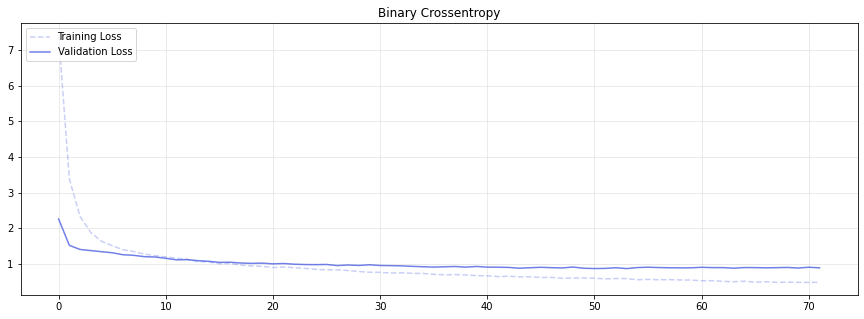

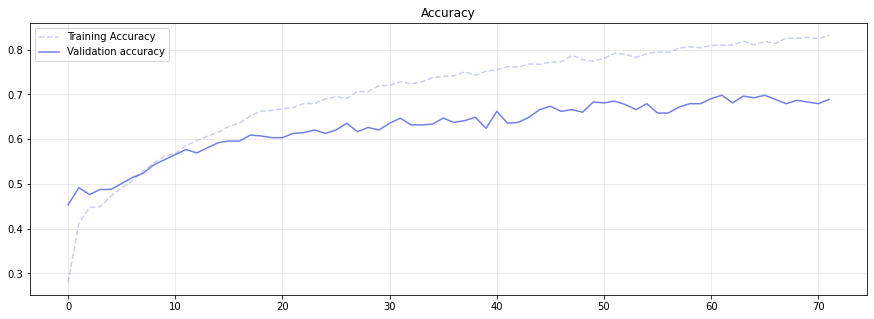

In [17]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [18]:
tl_model.save('Vgg16/FineFineTuning_v1')

In [19]:
tl_model = tfk.models.load_model('Vgg16/FineFineTuning_v1')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Output (Dense)              (None, 8)                 2056  

In [20]:
tl_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_1 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [21]:
for i, layer in enumerate(tl_model.get_layer('vgg16').layers[:15]):
  layer.trainable=False
for i, layer in enumerate(tl_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
tl_model.summary()

0 input_1 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 4608)              0         
                                                                 
 dropout (Dropout)           (None, 4608)              0       

In [22]:
tl_model.compile(loss='categorical_crossentropy', optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [ ]:
# Fine-tune the model
tl_history = tl_model.fit(
    x = aug_train_gen ,
    batch_size = 32,
    epochs = 200,
    validation_data = valid_gen,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, verbose=2 , restore_best_weights=True)],
    #class_weight = class_weight
).history

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))

plt.plot(tl_history['loss'],label = 'Training Loss', alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_loss'], label='Validation Loss', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))

plt.plot(tl_history['accuracy'],label = 'Training Accuracy' , alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Validation accuracy', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [ ]:
%cd /gdrive/My Drive/ANDL/Homework_1

In [ ]:
tl_model.save('Vgg16/Tuned_v1_1')

In [ ]:
# Test the model
tl_model = tfk.models.load_model("Vgg16/Tuned_v1_1")
model_test_metrics = tl_model.evaluate(test_gen, return_dict=True)

print()
print("Test metrics")
print(model_test_metrics)

In [ ]:
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

predictions = tl_model.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()